In [9]:
import pandas as pd
#pd.set_option('display.max_rows', None)
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib import path
import os
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
import numpy as np
import netCDF4 as nc
np.set_printoptions(threshold=100000)
from shapely.geometry import Polygon, Point, MultiPoint
from shapely.ops import cascaded_union
from datetime import datetime, timedelta
import time
import warnings
import datetime
import math
from scipy.ndimage.interpolation import shift
import shapely.wkt
from scipy.stats import pearsonr,spearmanr,kendalltau
from scipy.optimize import curve_fit 

warnings.filterwarnings('ignore')
import seaborn as sns
sns.set(font_scale=1.4) 
from my_functions import sat_vap_press, vap_press, hot_dry_windy, haines
from os.path import exists
import xarray as xr
from helper_functions import build_one_gridcell, calculate_intersection, calculate_grid_cell_corners, make_file_namelist, generate_df

In [132]:
times = pd.date_range(np.datetime64('2021-07-01')+np.timedelta64(12, 'h'),np.datetime64('2022-01-01'))
print(times)
rave_filenames,times_back_used = make_file_namelist(times,
                                                        '/data2/lthapa/YYYY/RAVE/MM/RAVE-HrlyEmiss-3km-CONUS_v1r1_blend_sYYYYMMDD.nc')                                                 
#print(rave_filenames)
daily_rave = np.zeros(len(times)) #fill this guy in

for ii in range(len(rave_filenames)-1):
    names = rave_filenames[[ii,ii+1]]
    #print(rave_filenames[[ii,ii+1]], times[ii])
    print(times[ii])

    rave_data = xr.open_mfdataset(names,concat_dim='time',combine='nested',compat='override', coords='all')
    
    lon_w = -125+360
    lon_e = -101+360
    lat_bot = 31
    lat_top = 49
    #select the rave data and sum up over time and 
    frp_sub = rave_data['FRP_MEAN']
    frp_sub = frp_sub.where((frp_sub.grid_lont>lon_w)&
                            (frp_sub.grid_lont<lon_e)&
                            (frp_sub.grid_latt>lat_bot)&
                            (frp_sub.grid_latt<lat_top))
    frp_sub_daily = frp_sub.resample(time='24H',base=12).sum(dim='time').sel(time=times[ii]) #take the daily sum
    frp_daily = rave_data['FRP_MEAN'].resample(time='24H', base=12).sum(dim='time').sel(time=times[ii])
    print(np.nansum(frp_sub_daily.values), np.nansum(frp_daily.values))
    
    daily_rave[ii]=np.nansum(frp_sub_daily.values)

DatetimeIndex(['2021-07-01 12:00:00', '2021-07-02 12:00:00',
               '2021-07-03 12:00:00', '2021-07-04 12:00:00',
               '2021-07-05 12:00:00', '2021-07-06 12:00:00',
               '2021-07-07 12:00:00', '2021-07-08 12:00:00',
               '2021-07-09 12:00:00', '2021-07-10 12:00:00',
               ...
               '2021-12-22 12:00:00', '2021-12-23 12:00:00',
               '2021-12-24 12:00:00', '2021-12-25 12:00:00',
               '2021-12-26 12:00:00', '2021-12-27 12:00:00',
               '2021-12-28 12:00:00', '2021-12-29 12:00:00',
               '2021-12-30 12:00:00', '2021-12-31 12:00:00'],
              dtype='datetime64[ns]', length=184, freq='D')
2021-07-01 12:00:00
225283.95 417345.94
2021-07-02 12:00:00
101134.16 440074.5
2021-07-03 12:00:00
115498.32 699906.44
2021-07-04 12:00:00
112187.03 248424.66
2021-07-05 12:00:00
148496.64 402372.6
2021-07-06 12:00:00
469561.5 921320.5
2021-07-07 12:00:00
692892.8 1028099.75
2021-07-08 12:00:00
1061514.8 1553

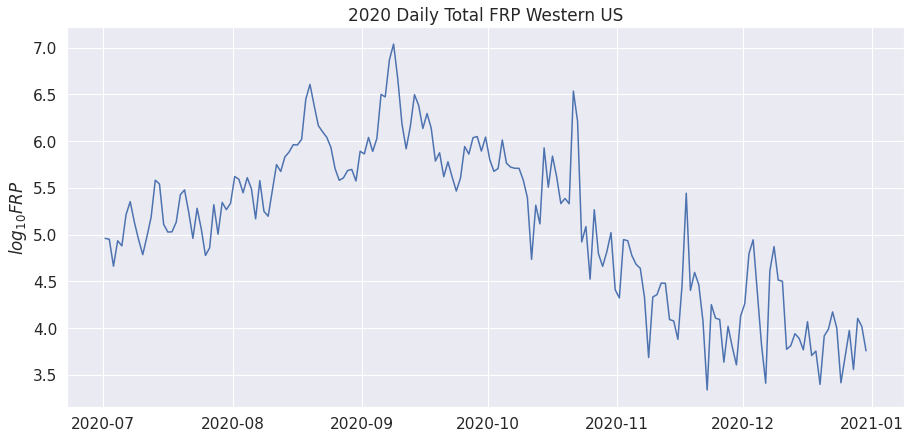

In [75]:
fig, ax = plt.subplots(figsize=(15,7))
plt.plot(times, np.log10(daily_rave))
plt.title('2020 Daily Total FRP Western US')
plt.ylabel("$log_{10} FRP$")
plt.show()

In [66]:
df = pd.DataFrame({'time':times, 'FRP':daily_rave})
df.to_csv('2019_Daily_RAVE_Totals.csv')

In [74]:
df = pd.DataFrame({'time':times, 'FRP':daily_rave})
df.to_csv('2020_Daily_RAVE_Totals.csv')

In [133]:
df = pd.DataFrame({'time':times, 'FRP':daily_rave})
df.to_csv('2021_Daily_RAVE_Totals.csv')

In [106]:
rave_2019 = pd.read_csv('2019_Daily_RAVE_Totals.csv')
rave_2019['logFRP'] = np.log10(rave_2019['FRP'])
rave_2019['time_days'] =pd.to_datetime(rave_2019['time']).dt.strftime('%m/%d')
rave_2019



,Unnamed: 0,time,FRP,logFRP,time_days
0,0,2019-07-01 12:00:00,76726.609375,4.884946,07/01
1,1,2019-07-02 12:00:00,68016.164062,4.832612,07/02
2,2,2019-07-03 12:00:00,69872.265625,4.844305,07/03
3,3,2019-07-04 12:00:00,104930.148438,5.020900,07/04
4,4,2019-07-05 12:00:00,69006.421875,4.838890,07/05
...,...,...,...,...,...
179,179,2019-12-27 12:00:00,438.236725,2.641709,12/27
180,180,2019-12-28 12:00:00,3728.790039,3.571568,12/28
181,181,2019-12-29 12:00:00,1419.885254,3.152253,12/29
182,182,2019-12-30 12:00:00,1259.748901,3.100284,12/30


In [111]:
rave_2020 = pd.read_csv('2020_Daily_RAVE_Totals.csv')
rave_2020['logFRP'] = np.log10(rave_2020['FRP'])
rave_2020['time_days'] =pd.to_datetime(rave_2020['time']).dt.strftime('%m/%d')
rave_2020


,Unnamed: 0,time,FRP,logFRP,time_days
0,0,2020-07-01 12:00:00,91258.960938,4.960276,07/01
1,1,2020-07-02 12:00:00,89194.804688,4.950340,07/02
2,2,2020-07-03 12:00:00,45910.406250,4.661911,07/03
3,3,2020-07-04 12:00:00,86009.093750,4.934544,07/04
4,4,2020-07-05 12:00:00,75793.781250,4.879634,07/05
...,...,...,...,...,...
179,179,2020-12-27 12:00:00,3598.708496,3.556147,12/27
180,180,2020-12-28 12:00:00,12723.595703,4.104610,12/28
181,181,2020-12-29 12:00:00,10385.238281,4.016416,12/29
182,182,2020-12-30 12:00:00,5709.992188,3.756636,12/30


In [134]:
rave_2021 = pd.read_csv('2021_Daily_RAVE_Totals.csv')
rave_2021['logFRP'] = np.log10(rave_2021['FRP'])
rave_2021['time_days'] =pd.to_datetime(rave_2021['time']).dt.strftime('%m/%d')
rave_2021

,Unnamed: 0,time,FRP,logFRP,time_days
0,0,2021-07-01 12:00:00,225283.953125,5.352730,07/01
1,1,2021-07-02 12:00:00,101134.156250,5.004898,07/02
2,2,2021-07-03 12:00:00,115498.320312,5.062576,07/03
3,3,2021-07-04 12:00:00,112187.031250,5.049943,07/04
4,4,2021-07-05 12:00:00,148496.640625,5.171717,07/05
...,...,...,...,...,...
179,179,2021-12-27 12:00:00,413.176758,2.616136,12/27
180,180,2021-12-28 12:00:00,2863.605469,3.456913,12/28
181,181,2021-12-29 12:00:00,7967.713867,3.901334,12/29
182,182,2021-12-30 12:00:00,36787.699219,4.565703,12/30


In [95]:
print((pd.to_datetime(rave_2020['time']).dt.strftime('%Y-%m')))

0      2020-07
1      2020-07
2      2020-07
3      2020-07
4      2020-07
        ...   
179    2020-12
180    2020-12
181    2020-12
182    2020-12
183    2020-12
Name: time, Length: 184, dtype: object


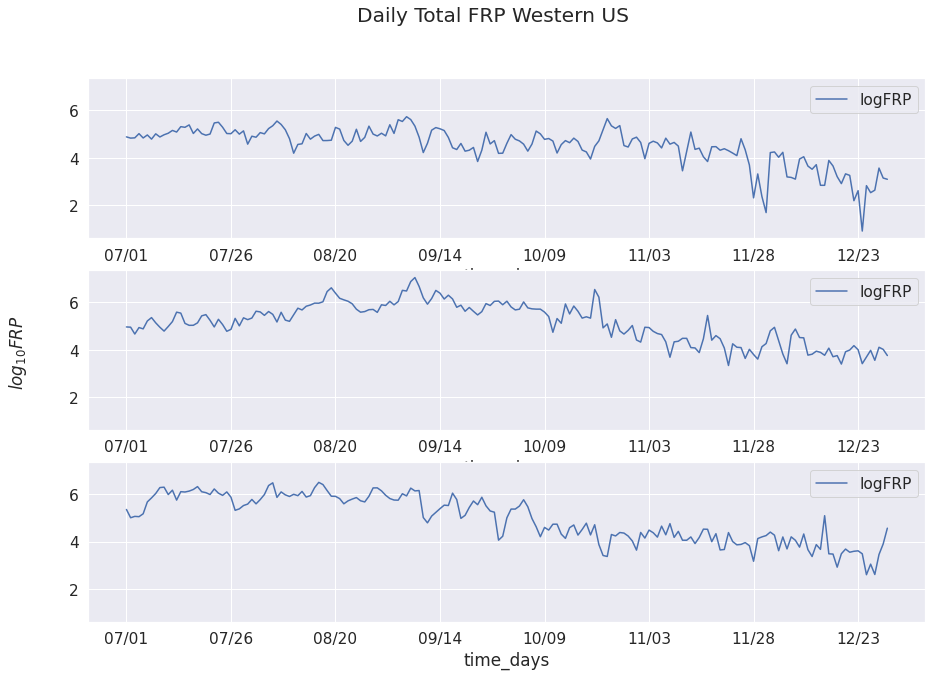

In [136]:
fig, axs = plt.subplots(3,1, figsize=(15,10), sharey=True)
rave_2019.plot(x='time_days', y='logFRP', ax=axs[0])
rave_2020.plot(x='time_days', y='logFRP', ax=axs[1])
rave_2021.plot(x='time_days', y='logFRP', ax=axs[2])

plt.suptitle('Daily Total FRP Western US')
fig.text(0.06, 0.5, "$log_{10} FRP$", ha='center', va='center', rotation='vertical')
plt.show()